In [5]:
import sys
sys.path.append('/u/ajagadish/ermi/categorisation/')
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import json
import math
import time
import warnings

# Machine learning and statistics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct
import statsmodels.api as sm

# Optimization and curve fitting
from scipy.optimize import curve_fit, OptimizeWarning

# Environment and path management
from os import getenv
from dotenv import load_dotenv

# Other specialized imports
from wordcloud import WordCloud
from collections import Counter
import torch.nn.functional as F
from groupBMC.groupBMC import GroupBMC
from matplotlib.patches import Patch
FONTSIZE=20
SYS_PATH = '/u/ajagadish/ermi'
PARADIGM_PATH = f"{SYS_PATH}/categorisation"

from plots import model_comparison_badham2017, model_simulations_smith1998, model_simulations_shepard1961, model_comparison_devraj2022, model_comparison_johanssen2002, plot_dataset_statistics, compare_data_statistics, compare_inputfeatures, plot_frequency_tasklabels, compare_stats_across_models

In [6]:
def plot_frequency_tasklabels(file_name, path='/u/ajagadish/vanilla-llama/categorisation/data/tasklabels', feature_names=True, pairs=True, top_labels=50):

    df = pd.read_csv(f'{path}/{file_name}.csv')
    df.feature_names = df['feature_names'].apply(lambda x: eval(x))
    df.category_names = df['category_names'].apply(lambda x: eval(x))
    
    def to_lower(ff):
        return [x.lower() for x in ff]
    
    df.feature_names = df['feature_names'].apply(lambda x: to_lower(x))
    df.category_names = df['category_names'].apply(lambda x: to_lower(x))

    # name of the column containing the feature names
    column_name = 'feature_names' if feature_names else 'category_names'
    # count of number of times a type of features occurs
    list_counts = Counter([tuple(features) for features in df[column_name]] if pairs else np.stack(df[column_name].values).reshape(-1))

    # sort the Counter by counts in descending order
    sorted_list_counts = sorted(list_counts.items(), key=lambda x: x[1], reverse=True)

    # extract the counts and names for the top 50 labels
    task_labels = np.array([task_label[0] for task_label in sorted_list_counts[:top_labels]])
    label_counts= np.array([task_label[1] for task_label in sorted_list_counts[:top_labels]])
    label_names = ['-'.join(task_labels[idx]) for idx in range(len(task_labels))] if pairs else task_labels

    # plot the bars of labels and counts
    f, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.bar(label_names, label_counts)
    plt.xticks(label_names, label_names, rotation=90, fontsize=FONTSIZE-6.5)
    plt.yticks(fontsize=FONTSIZE-6)
    ax.set_xlabel('Feature Names' if feature_names else 'Category Names', fontsize=FONTSIZE)
    ax.set_ylabel('Counts', fontsize=FONTSIZE)
    ax.set_title(f'Top {top_labels} Tasks', fontsize=FONTSIZE)
    sns.despine()
    f.tight_layout()
    plt.show()
    
    # f.savefig(f'{SYS_PATH}/figures/frequency_plot_tasklabels_{column_name}_paired={pairs}_top{top_labels}.png', bbox_inches='tight', dpi=300)


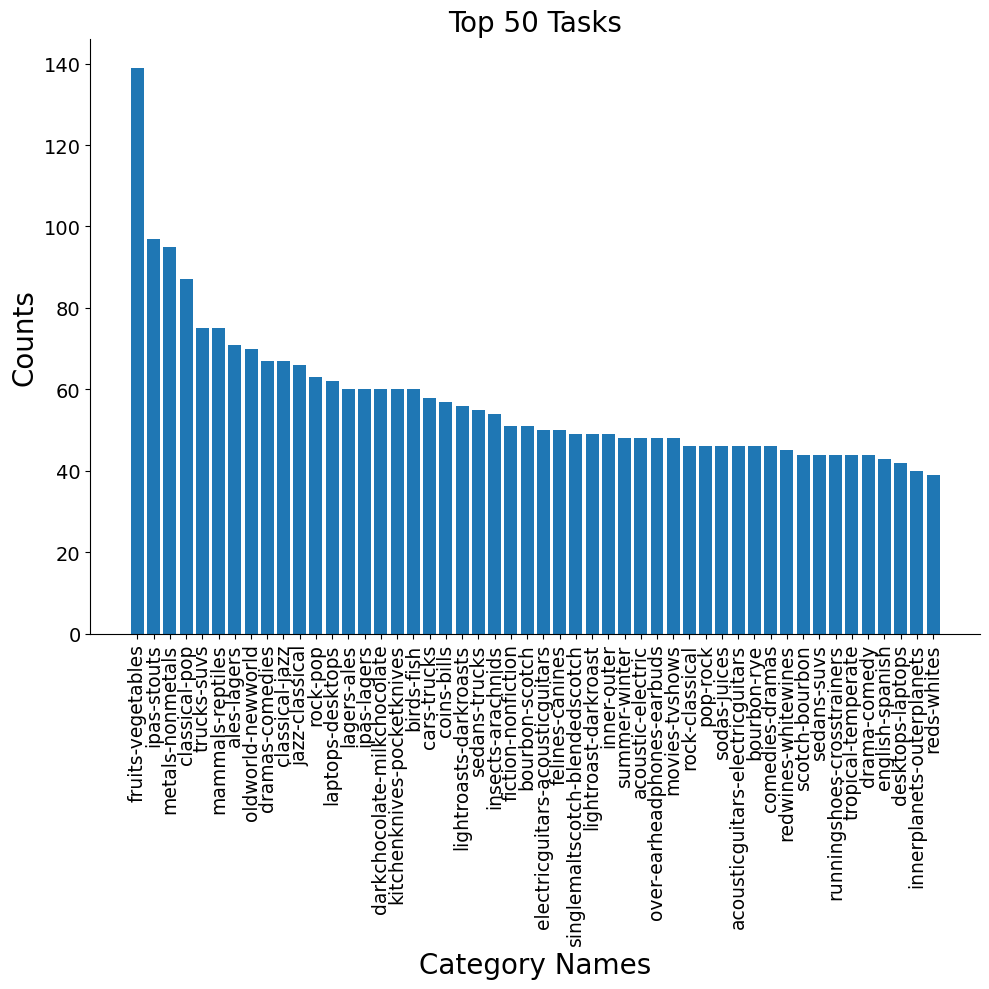

In [ ]:
path = f'{SYS_PATH}/categorisation/data/task_labels'
file_name = 'claude_generated_tasklabels_paramsNA_dim3_tasks23421_pversion5'
plot_frequency_tasklabels(file_name, path, feature_names=False)

In [5]:
def compare_data_statistics(modes):
    """Visualise four statistics for two datasets side‑by‑side with split violins.

    Parameters
    ----------
    modes : list[int]
        Exactly two integer codes identifying the data sources to compare.
        Accepted values are 0, 1, 2, 3 (see mapping below).
    """

    if len(modes) != 2:
        raise ValueError("This function expects *exactly* two modes to create a split violin plot.")

    # --------------------------------------------------------
    # 1. Metadata (file paths, colours, labels)
    # --------------------------------------------------------
    names_for_modes = {
        0: {
            "label": "LLM",
            "path": f"{SYS_PATH}/categorisation/data/generated_tasks/claude_generated_tasks_paramsNA_dim4_data650_tasks8950_pversion5_stage1",
            "colour": "#407193",
        },
        1: {
            "label": "MI",
            "path": f"{SYS_PATH}/categorisation/data/reference_tasks/linear_data",
            "colour": "#CA8243",
        },
        2: {
            "label": "Real",
            "path": f"{SYS_PATH}/categorisation/data/reference_tasks/real_data",
            "colour": "#CA8243",
        },
        3: {
            "label": "PFN",
            "path": f"{SYS_PATH}/categorisation/data/generated_tasks/synthetic_tasks_dim4_data650_tasks1000_nonlinearTrue",
            "colour": "#505050",
        },
    }

    # Resolve the meta information for the selected modes
    meta = [names_for_modes[m] for m in modes]

    # --------------------------------------------------------
    # 2. Collect the statistics
    # --------------------------------------------------------
    all_data = {0: [], 1: [], 2: [], 3: []}  # four stats × two modes
    accuracies = []
    for idx, mode in enumerate(modes):
        stats_path = f"{SYS_PATH}/categorisation/data/stats/stats_{mode}.npz"
        if not os.path.exists(stats_path):
            raise FileNotFoundError(f"Statistics not computed for mode {mode} – expected file {stats_path}")

        stats = np.load(stats_path, allow_pickle=True)
        accuracies.append(stats['all_accuraries_linear'].ravel())
        # Each of these is already a 1‑D array except `all_features_with_norm`, which
        # is (#tasks, #dims). Flatten to 1‑D so seaborn can plot a distribution.
        # all_data[0].append(stats["all_features_with_norm"].ravel())
        all_data[0].append(stats["all_corr"].ravel())
        all_data[1].append(stats["gini_coeff"].ravel())
        all_data[2].append(stats["posterior_logprob"].ravel())

    # --------------------------------------------------------
    # 3. Plot setup
    # --------------------------------------------------------
    # sns.set_theme("whitegrid", rc={"axes.facecolor": "#F9F9F9"})
    palette = [meta[0]["colour"], meta[1]["colour"]]

    # fig, axs = plt.subplots(1, 4, figsize=(4 * 6, 4), sharey=False)
    # titles = ["Input features", "Input correlation", "Sparsity", "Linearity"]
    # xlabels = ["Normalised value", "Pearson r", "Gini coefficient", "Posterior probability"]
    # ylims = [(0, 1), (-1, 1), (0, 0.8), (0, 1)]

    
    fig, axs = plt.subplots(1, 4, figsize=(4 * 6, 4), sharey=False)
    titles = ["Input correlation", "Sparsity", "Linearity", "Accuracy",]
    xlabels = [ "Pearson r", "Gini coefficient", "Posterior probability","Trial",]
    ylims = [(-1, 1), (0, 0.8), (0, 1), (0.45, 1)] # (-1, 1), 
    
    # ------------- accuracy subplot -------------
    ax0 = axs[0]
#     for idx, acc in enumerate(accuracies):
#         ax0.plot(np.arange(len(acc)), acc, color=palette[idx], lw=3, label=meta[idx]['label'], alpha=1.0)

    # plot mean accuracy with SEM shading
    for idx, acc in enumerate(accuracies):
        # acc: array of shape (n_runs, n_trials)
        arr = np.array(acc)
        if arr.ndim == 1:
            mean_acc = arr
            sem_acc = np.zeros_like(arr)
        else:
            mean_acc = arr.mean(axis=0)
            sem_acc = arr.std(axis=0, ddof=1) / np.sqrt(arr.shape[0])
        x_vals = np.arange(len(mean_acc))
        ax0.plot(x_vals, mean_acc, color=palette[idx], lw=3, label=meta[idx]['label'], alpha=1.0)
        ax0.fill_between(x_vals, mean_acc - sem_acc, mean_acc + sem_acc,
                         color=palette[idx], alpha=0.8)
    ax0.set_xlabel(xlabels[-1], fontsize=FONTSIZE+2)
    ax0.set_ylabel('Accuracy', fontsize=FONTSIZE)
    ax0.tick_params(axis="y", labelsize=FONTSIZE)
    ax0.tick_params(axis="x", labelsize=FONTSIZE)
    ax0.set_ylim(*ylims[-1])
    sns.despine(ax=ax0, left=False, bottom=False)

    # --------------------------------------------------------
    # 4. Create one split violin per statistic
    # --------------------------------------------------------
    for stat_idx, ax in enumerate(axs[1:]):
        # Build a tidy DataFrame for seaborn
        df_plot = pd.DataFrame({
            "value": np.concatenate([all_data[stat_idx][0], all_data[stat_idx][1]]),
            "group": np.repeat([meta[0]["label"], meta[1]["label"]],
                                 [len(all_data[stat_idx][0]), len(all_data[stat_idx][1])]),
            "stat": titles[stat_idx],
        })

        sns.violinplot(
            data=df_plot,
            x="stat",            # constant, so all violins share the same x pos
            y="value",
            hue="group",
            split=True,
            inner="box",
            palette=palette,
            saturation=0.9,
            linewidth=1.2,
            ax=ax,
        )

        # Aesthetics ---------------------------------------------------------
        ax.set_xlabel(xlabels[stat_idx], fontsize=FONTSIZE + 2)#, weight="bold")
        # ax.set_title(titles[stat_idx], fontsize=FONTSIZE + 2, pad=14)
        ax.set_ylim(*ylims[stat_idx])
        ax.set_xticks([])            # Remove redundant x‑tick (title already states the stat)
        ax.tick_params(axis="y", labelsize=FONTSIZE)
        sns.despine(ax=ax, left=False, bottom=True)
        ax.get_legend().remove()

        if stat_idx == 0:
            ax.set_ylabel("Density", fontsize=FONTSIZE)#, weight="bold")
        else:
            ax.set_ylabel("")

    # --------------------------------------------------------
    # 5. Single legend above all subplots
    # --------------------------------------------------------
    legend_elements = [Patch(facecolor=palette[0], edgecolor="white", label=meta[0]["label"]),
                       Patch(facecolor=palette[1], edgecolor="white", label=meta[1]["label"])]
    fig.legend(handles=legend_elements,
               ncol=2,
               loc="upper center",
               bbox_to_anchor=(0.5, 1.1),
               frameon=False,
               fontsize=FONTSIZE)

    fig.tight_layout()
    plt.subplots_adjust(top=0.85)

    # Optional: save figure --------------------------------------------------
    out_path = f"{SYS_PATH}/figures/compare_stats_split_violin_{modes[0]}_{modes[1]}.svg"
    fig.savefig(out_path, bbox_inches="tight", dpi=300)
    plt.show()

    # Reset seaborn to default state so the style does not bleed into other plots
    sns.reset_defaults()

    return out_path

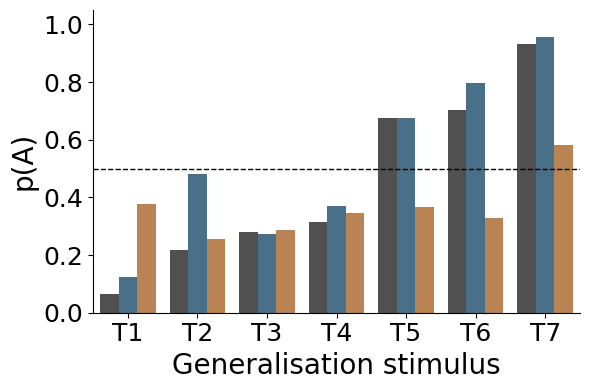

'/u/ajagadish/ermi/figures/model_comparison_johanssen2002_merged_main.svg'

In [6]:
# # plot_dataset_statistics(0)
# # plot_dataset_statistics(1)
# # plot_dataset_statistics(2)
# # plot_dataset_statistics(3)
# model_simulations_shepard1961('main')
# # model_simulations_shepard1961('supplementary')
# model_comparison_badham2017()
# model_simulations_smith1998('main')
# # model_simulations_smith1998('supplementary')
# model_comparison_devraj2022()
model_comparison_johanssen2002('main')
# # model_comparison_johanssen2002('supplementary')
# # plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim3_tasks23421_pversion5', feature_names=False, pairs=False)
# # plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim3_tasks23421_pversion5', feature_names=True, pairs=False)
# # plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim4_tasks20690_pversion5', feature_names=False, pairs=False)
# # plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim4_tasks20690_pversion5', feature_names=True, pairs=False)
# # plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim6_tasks13693_pversion5', feature_names=False, pairs=False)
# # plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim6_tasks13693_pversion5', feature_names=True, pairs=False)

# # # rebuttals
# # model_simulations_shepard1961(num_blocks=6)
# # model_simulations_shepard1961('supplementary', num_blocks=6)
# compare_data_statistics([2,0])
# # compare_data_statistics([2,1])
# # compare_data_statistics([2,3])
# # model_simulations_shepard1961('rebuttals', num_blocks=6)
# # compare_inputfeatures([2, 0,])
# # compare_inputfeatures([2, 0, 1, 3])
# # compare_stats_across_models([2, 0, 1, 3], feature='input_features')
# # compare_stats_across_models([2, 0, 1, 3], feature='input_correlation')
# # compare_stats_across_models([2, 0, 1, 3], feature='gini_coefficient')
# # compare_stats_across_models([2, 0, 1, 3], feature='posterior_logprob')
# # compare_stats_across_models([2, 0, 1, 3], feature='performance')
# # #slides
# # compare_stats_across_models([2, 0, 1], feature='input_features')
# # compare_stats_across_models([2, 0, 1], feature='input_correlation')
# # compare_stats_across_models([2, 0, 1], feature='gini_coefficient')
# # compare_stats_across_models([2, 0, 1], feature='posterior_logprob')
# # compare_stats_across_models([2, 0, 1], feature='performance')





In [7]:
import json, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from matplotlib.patches import Patch

def model_simulations_shepard1961(plot='main', num_blocks=15, tasks=np.arange(1, 7)):
    # ---------------------------------------------------------------------
    # 1.  Decide which models to show
    # ---------------------------------------------------------------------
    if plot == 'main':
        models = [
            'humans',
            'env=claude_generated_tasks_paramsNA_dim3_data100_tasks11518_pversion4_'
            'model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_'
            'd_model=64_num_head=8_noise0.0_shuffleTrue_run=0',
            'env=dim3synthetic_model=transformer_num_episodes500000_num_hidden=256_'
            'lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic',
        ]
    elif plot == 'supplementary':
        models = [
            'humans',
            'env=rmc_tasks_dim3_data100_tasks11499_model=transformer_num_episodes500000_'
            'num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=1_rmc',
            'env=dim3synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_'
            'd_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_nonlinear',
        ]
    elif plot == 'rebuttals':
        models = [
            'humans',
            'env=claude_generated_tasks_paramsNA_dim3_data100_tasks11518_pversion4_'
            'model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_'
            'd_model=64_num_head=8_noise0.0_shuffleTrue_run=0',
            'LLM',
        ]
    else:
        raise ValueError("plot must be 'main', 'supplementary', or 'rebuttals'")

    # ---------------------------------------------------------------------
    # 2.  Pre-allocate arrays & colours
    # ---------------------------------------------------------------------
    num_trials_per_block = 16
    num_runs = 50
    errors = np.ones((len(models), len(tasks), num_blocks))
    betas = []

    # Choose one neutral grey for humans + two colour-blind friendly hues
    base_palette = ['#505050', '#407193', '#CA8243']
    # Use seaborn palette if more models than predefined colours
    if len(models) > len(base_palette):
        colors = sns.color_palette("colorblind", len(models))
    else:
        colors = base_palette[:len(models)]

    # ---------------------------------------------------------------------
    # 3.  Collect error curves for each model
    # ---------------------------------------------------------------------
    for m_idx, model in enumerate(models):

        # ---------- Humans ----------
        if model == 'humans':
            betas.append(None)

        # ---------- Pre-computed LLM simulation ----------
        elif model == 'LLM':
            block_errors = np.load(
                f'{SYS_PATH}/categorisation/data/stats/shepard1961_llm_simulations.npz',
                allow_pickle=True
            )
            errors[m_idx] = block_errors['block_errors'] + 0.1  # small offset
            betas.append(None)

        # ---------- Transformers (ERMI / MI / PFN / RMC) ----------
        else:
            NUM_BLOCKS = 15  # fixed during fitting
            if 'claude' in model:
                model_name = 'ermi'
            elif 'rmc' in model:
                model_name = 'rmc'
            elif 'synthetic_nonlinear' in model:
                model_name = 'pfn'
            else:
                model_name = 'mi'

            mse_distances, beta_range = np.load(
                f'{SYS_PATH}/categorisation/data/fitted_simulation/'
                f'shepard1961_{model_name}_num_runs={num_runs}_num_blocks={NUM_BLOCKS}_'
                f'num_trials_per_block={num_trials_per_block}.npy',
                allow_pickle=True
            )
            block_errors = np.load(
                f'{SYS_PATH}/categorisation/data/fitted_simulation/'
                f'shepard1961_{model_name}_num_runs={num_runs}_num_blocks={NUM_BLOCKS}_'
                f'num_trials_per_block={num_trials_per_block}_block_errors.npy',
                allow_pickle=True
            )
            best_beta_idx = int(np.argmin(mse_distances))
            betas.append(beta_range[best_beta_idx])
            errors[m_idx] = block_errors[best_beta_idx, 1][:, :num_blocks]

    # ---------------------------------------------------------------------
    # 4.  Load human data for reference
    # ---------------------------------------------------------------------
    with open(f'{SYS_PATH}/categorisation/data/human/nosofsky1994.json') as jf:
        data = json.load(jf)

    # ---------------------------------------------------------------------
    # 5.  Plot
    # ---------------------------------------------------------------------
    FONTSIZE = 16
    fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 4))
    markers = ['o', 'x', '+', '*', 'v', '^']  # one per task

    # ---- Helper to get display names & legend handles ----
    def display_name(model_str):
        if model_str == 'humans':
            return 'Human'
        if 'claude' in model_str:
            return 'ERMI'
        if 'rmc' in model_str:
            return 'RMC'
        if 'synthetic_nonlinear' in model_str:
            return 'PFN'
        if 'synthetic' in model_str:
            return 'MI'
        if model_str == 'LLM':
            return 'LLM'
        return model_str

    model_handles = [
        Patch(facecolor=colors[i], label=display_name(models[i]))
        for i in range(len(models))
    ]

    # ---- Plot each panel ----
    for idx, ax in enumerate(axes):

        if models[idx] == 'humans':
            for i, rule in enumerate(data.keys()):
                ax.plot(
                    np.arange(1, num_blocks + 1),
                    data[rule]['y'][:num_blocks],
                    lw=3,
                    color=colors[idx],
                    marker=markers[i],
                    markersize=8,
                    alpha=(i + 1) / len(data),
                )
        else:
            for t_idx, task in enumerate(tasks):
                ax.plot(
                    np.arange(1, num_blocks + 1),
                    errors[idx, t_idx],
                    lw=3,
                    color=colors[idx],
                    marker=markers[t_idx],
                    markersize=8,
                    alpha=(t_idx + 1) / len(tasks),
                )

        # Common axis formatting
        ax.set_xticks(np.arange(1, num_blocks + 1)[::2])
        ax.set_xticklabels(np.arange(1, num_blocks + 1)[::2], fontsize=FONTSIZE - 2)
        ax.set_ylim([-0.01, 0.55])
        ax.tick_params(axis='y', labelsize=FONTSIZE - 2)
        if idx == 0:
            ax.set_xlabel('Block', fontsize=FONTSIZE)
            ax.set_ylabel('P(Error)', fontsize=FONTSIZE)

    # ---------------------------------------------------------------------
    # 6.  Figure-level legend (models) and layout tweaks
    # ---------------------------------------------------------------------
    fig.legend(
        handles=model_handles,
        loc='upper center',
        bbox_to_anchor=(0.3, 0.9),
        ncol=1,
        frameon=False,
        fontsize=FONTSIZE,
    )

    sns.despine()
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # leave room for legend
    plt.show()

    fig.savefig(
        f'{SYS_PATH}/figures/model_simulations_shepard1961.svg',
        bbox_inches='tight',
        dpi=300,
    )


In [3]:

def model_comparison_johanssen2002(plot="main", task_block=32):
    """Compare human generalisation with ERMI and MI (or PFN) in *one* bar plot.

    Parameters
    ----------
    plot : {'main', 'alt'}
        'main' ➜ ERMI vs. MI / 'any other' ➜ ERMI vs. PFN.
    task_block : int
        Identifier for the task feature block (default = 32).
    """

    # ----------------------------------------------------------
    # Helper → fetch beta and read CSVs for the three sources
    # ----------------------------------------------------------
    def load_transfer_df(beta_path_tmpl, csv_tmpl):
        beta = np.load(beta_path_tmpl.format(tb=task_block))
        df = pd.read_csv(csv_tmpl.format(beta=beta, tb=task_block))
        # keep only transfer stimuli for the requested task block
        ids = df[df["stimulus_id"].str.contains("T")]["stimulus_id"]
        df = df[df["stimulus_id"].isin(ids) & (df["task_feature"] == task_block)]
        return df

    # Paths ----------------------------------------------------
    ermi_beta_p = f"{SYS_PATH}/categorisation/data/meta_learner/johanssen_categorisation_ermi_{task_block}_best_beta.npy"
    mi_beta_p   = f"{SYS_PATH}/categorisation/data/meta_learner/johanssen_categorisation_mi_{task_block}_best_beta.npy"
    pfn_beta_p  = f"{SYS_PATH}/categorisation/data/meta_learner/johanssen_categorisation_pfn_{task_block}_best_beta.npy"

    ermi_csv = (f"{SYS_PATH}/categorisation/data/meta_learner/"
                "johanssen_categorisation__tasks8950_pversion5_stage1_model=transformer_"
                "num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_"
                "num_head=8_noise0.0_shuffleTrue_run=1_beta={beta}_num_trials=288_num_runs=1.csv")

    mi_csv = (f"{SYS_PATH}/categorisation/data/meta_learner/"
              "johanssen_categorisation_500000_num_hidden=256_lr0.0003_num_layers=6_"
              "d_model=64_num_head=8_noise0.0_shuffleTrue_run=1_synthetic_beta={beta}_num_trials=288_num_runs=1.csv")

    pfn_csv = (f"{SYS_PATH}/categorisation/data/meta_learner/"
               "johanssen_categorisation_500000_num_hidden=256_lr0.0003_num_layers=6_"
               "d_model=64_num_head=8_noise0.0_shuffleTrue_run=1_syntheticnonlinear_beta={beta}_num_trials=288_num_runs=1.csv")

    ermi_df = load_transfer_df(ermi_beta_p, ermi_csv)
    mi_df   = load_transfer_df(mi_beta_p, mi_csv)
    pfn_df  = load_transfer_df(pfn_beta_p, pfn_csv)

    # ----------------------------------------------------------
    # Human data
    # ----------------------------------------------------------
    with open(f"{SYS_PATH}/categorisation/data/human/johanssen2002.json") as f:
        human_raw = json.load(f)
    human_df = pd.DataFrame({"stimulus_id": human_raw["x"], "prob_A": human_raw["y"]})
    human_df = human_df[human_df["stimulus_id"].str.contains("T")]

    # ----------------------------------------------------------
    # Compute mean p(A) for each stimulus across runs
    # ----------------------------------------------------------
    def compute_model_mean(df):
        return 1 - df.groupby("stimulus_id")["choice"].mean()

    human_series = human_df.set_index("stimulus_id")["prob_A"]
    ermi_series  = compute_model_mean(ermi_df)
    mi_series    = compute_model_mean(mi_df)
    pfn_series   = compute_model_mean(pfn_df)

    # Align order with ascending human generalisation (as in original paper)
    order = human_series.sort_values().index
    human_series = human_series[order]
    ermi_series  = ermi_series[order]
    mi_series    = mi_series[order]
    pfn_series   = pfn_series[order]

    # ----------------------------------------------------------
    # One‑hot labels for x‑ticks
    # ----------------------------------------------------------
    one_hot_map = {
        "T1": "1 0 1 1", "T2": "1 0 1 0", "T3": "0 1 1 1",
        "T4": "1 1 0 1", "T5": "1 1 0 0", "T6": "0 1 1 0", "T7": "0 0 0 0",
    }
    x_labels = [f'T{i+1}' for i in range(len(human_series))] #[one_hot_map[t] for t in order]

    # ----------------------------------------------------------
    # Build tidy DataFrame for seaborn
    # ----------------------------------------------------------
    model_to_series = {
        "Human": human_series,
        "ERMI": ermi_series,
        "MI": mi_series,
        "PFN": pfn_series,
    }
    if plot == "main":
        selected_models = ["Human", "ERMI", "MI"]
    else:
        selected_models = ["Human", "ERMI", "PFN"]

    df_plot = pd.concat([
        pd.DataFrame({"stimulus": x_labels, "prob_A": model_to_series[m].values, "model": m})
        for m in selected_models
    ])

    # ----------------------------------------------------------
    # Plot with seaborn
    # ----------------------------------------------------------
    # sns.set_theme("whitegrid", rc={"axes.facecolor": "#F9F9F9"})
    palette = ["#505050", "#407193", "#CA8243"] if plot == "main" else ["#505050", "#407193", "#66828F"]

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(data=df_plot, x="stimulus", y="prob_A", hue="model", palette=palette, ax=ax, width=0.8, edgecolor="black")

    # Reference line & aesthetics
    ax.axhline(0.5, ls="--", c="black", lw=1)
    ax.set_xlabel("Generalisation stimulus", fontsize=FONTSIZE)#, weight="bold")
    ax.set_ylabel("p(A)", fontsize=FONTSIZE)#, weight="bold")
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.tick_params(axis="both", labelsize=FONTSIZE-2)
    ax.set_ylim(0, 1.05)
    ax.get_legend().remove()
    # ax.legend(title="Model", fontsize=FONTSIZE - 1, title_fontsize=FONTSIZE)
    sns.despine(ax=ax)
    fig.tight_layout()

    out_path = f"{SYS_PATH}/figures/model_comparison_johanssen2002_merged_{plot}.svg"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    sns.reset_defaults()
    return out_path


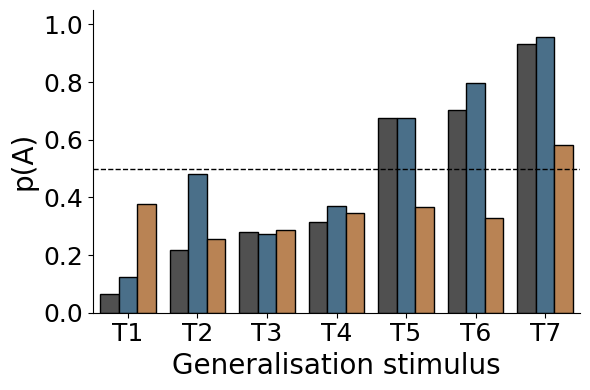

'/u/ajagadish/ermi/figures/model_comparison_johanssen2002_merged_main.svg'

In [73]:
# plot_dataset_statistics(0)
# plot_dataset_statistics(1)
# plot_dataset_statistics(2)
# plot_dataset_statistics(3)
model_simulations_shepard1961('main')
# model_simulations_shepard1961('supplementary')
model_comparison_badham2017()
model_simulations_smith1998('main')
# model_simulations_smith1998('supplementary')
model_comparison_devraj2022()
model_comparison_johanssen2002('main')
# model_comparison_johanssen2002('supplementary')
# plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim3_tasks23421_pversion5', feature_names=False, pairs=False)
# plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim3_tasks23421_pversion5', feature_names=True, pairs=False)
# plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim4_tasks20690_pversion5', feature_names=False, pairs=False)
# plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim4_tasks20690_pversion5', feature_names=True, pairs=False)
# plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim6_tasks13693_pversion5', feature_names=False, pairs=False)
# plot_frequency_tasklabels('claude_generated_tasklabels_paramsNA_dim6_tasks13693_pversion5', feature_names=True, pairs=False)

# # rebuttals
# model_simulations_shepard1961(num_blocks=6)
# model_simulations_shepard1961('supplementary', num_blocks=6)
# compare_data_statistics([2,0])
# compare_data_statistics([2,1])
# compare_data_statistics([2,3])
# model_simulations_shepard1961('rebuttals', num_blocks=6)
compare_inputfeatures([2, 0,])
# compare_inputfeatures([2, 0, 1, 3])
# compare_stats_across_models([2, 0, 1, 3], feature='input_features')
# compare_stats_across_models([2, 0, 1, 3], feature='input_correlation')
# compare_stats_across_models([2, 0, 1, 3], feature='gini_coefficient')
# compare_stats_across_models([2, 0, 1, 3], feature='posterior_logprob')
# compare_stats_across_models([2, 0, 1, 3], feature='performance')
# #slides
# compare_stats_across_models([2, 0, 1], feature='input_features')
# compare_stats_across_models([2, 0, 1], feature='input_correlation')
# compare_stats_across_models([2, 0, 1], feature='gini_coefficient')
# compare_stats_across_models([2, 0, 1], feature='posterior_logprob')
# compare_stats_across_models([2, 0, 1], feature='performance')



